# HOURLY BIKE RENTAL PREDICTION

In [1]:
#IMPORTING LIBRARIES
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import date
#import calendar
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#LOADING DATASET
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.shape, test.shape

((12980, 12), (4399, 11))

In [4]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 0:00:00,1,0,0,1,9.84,14.395,81.0,0.0,3,13,16
1,2011-01-01 1:00:00,1,0,0,1,9.02,13.635,80.0,0.0,8,32,40
2,2011-01-01 2:00:00,1,0,0,1,9.02,13.635,80.0,0.0,5,27,32
3,2011-01-01 3:00:00,1,0,0,1,9.84,14.395,75.0,0.0,3,10,13
4,2011-01-01 4:00:00,1,0,0,1,9.84,14.395,75.0,0.0,0,1,1


In [5]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered
0,2012-06-30 1:00:00,3,0,0,3,26.24,28.790,89.0,15.0013,3,55
1,2012-06-30 2:00:00,3,0,0,2,26.24,28.790,89.0,0.0000,7,54
2,2012-06-30 3:00:00,3,0,0,2,26.24,28.790,89.0,0.0000,3,20
3,2012-06-30 4:00:00,3,0,0,2,25.42,27.275,94.0,0.0000,3,15
4,2012-06-30 5:00:00,3,0,0,1,26.24,28.790,89.0,11.0014,3,7


In [6]:
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [7]:
test.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered'],
      dtype='object')

In [8]:
train.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity      float64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

# Univariate Analysis

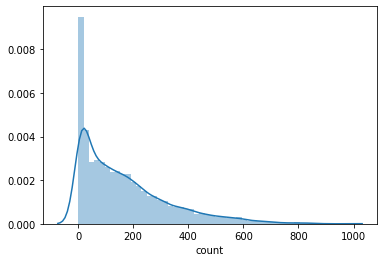

In [9]:
#distribution of count variable
sn.distplot(train["count"])

As, we can see the distribution for 'count' variable is right skewed.Hence we can take log of the variable and see if the distribution becomes normal.

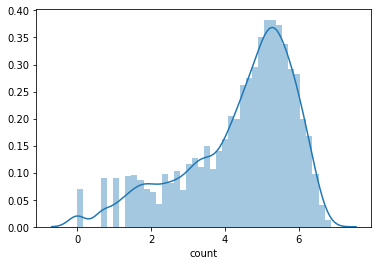

In [10]:
sn.distplot(np.log(train["count"]))

Now the distribution looks less skewed.

Let's now look at how correlated our numerical variables are. 
We will see the correlation between each of these variables and the variable which have high negative or positive values are correlated. By this we can get an overview of the variables which might affect our target variable.

# Bivariate Analysis

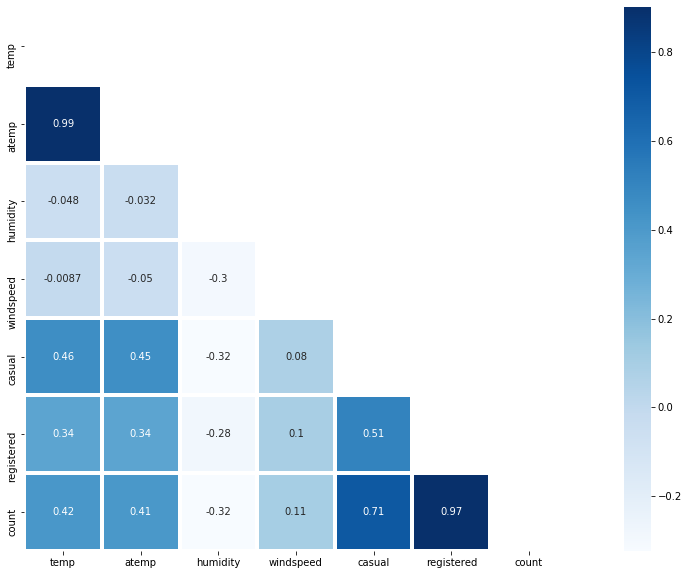

In [11]:
corr = train[['temp','atemp','humidity','windspeed','casual','registered','count']].corr()
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corr, mask= np.triu(corr), square = True,fmt = '.2g', vmax = .9, annot = True, cmap= 'Blues', linewidth = 3)

# Some of the inferences from the above correlation map are:

1) temp and humidity features has got positive and negative correlation with count respectively.Although the correlation            between them are not very prominent still the count variable has got little dependency on "temp" and "humidity".

2) windspeed will not be really useful numerical feature and it is visible from it correlation value with "count"

3) Since "atemp" and "temp" has got strong correlation with each other, during model building any one of the variable has to be      dropped since they will exhibit multicollinearity in the data.

In [12]:
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [13]:
test.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
dtype: int64

There are no missing values in the train and test dataset.
Now, I have extracted some new features using the datetime variable.

In [14]:
train['date'] = train.datetime.apply(lambda x : x.split()[0])
train['hour'] = train.datetime.apply(lambda x : x.split()[1].split(':')[0])
train["month"] = train.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").month)

In [15]:
test["date"] = test.datetime.apply(lambda x : x.split()[0])
test["hour"] = test.datetime.apply(lambda x : x.split()[1].split(":")[0])
test["month"] = test.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").month)

In [16]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,month
0,2011-01-01 0:00:00,1,0,0,1,9.84,14.395,81.0,0.0,3,13,16,2011-01-01,0,1
1,2011-01-01 1:00:00,1,0,0,1,9.02,13.635,80.0,0.0,8,32,40,2011-01-01,1,1
2,2011-01-01 2:00:00,1,0,0,1,9.02,13.635,80.0,0.0,5,27,32,2011-01-01,2,1
3,2011-01-01 3:00:00,1,0,0,1,9.84,14.395,75.0,0.0,3,10,13,2011-01-01,3,1
4,2011-01-01 4:00:00,1,0,0,1,9.84,14.395,75.0,0.0,0,1,1,2011-01-01,4,1


Now data is ready. Before making the model, I have divided the train set into training and validation set. I will train the model on the training set and check its performance on the validation set.I have created a validation set to validate the model. Since the data is time based, I will split it as per time. I have taken first 15 months for training and remaining 3 months in the validation set. 

In [17]:
training = train[train['datetime']<='2012-03-30 0:00:00']
validation = train[train['datetime']>'2012-03-30 0:00:00']

In [18]:
training.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,month
10769,2012-03-29 20:00:00,2,0,1,1,18.86,22.725,38.0,19.9995,34,301,335,2012-03-29,20,3
10770,2012-03-29 21:00:00,2,0,1,1,18.04,21.970,44.0,19.0012,10,214,224,2012-03-29,21,3
10771,2012-03-29 22:00:00,2,0,1,1,17.22,21.210,44.0,19.0012,17,135,152,2012-03-29,22,3
10772,2012-03-29 23:00:00,2,0,1,1,17.22,21.210,47.0,19.9995,17,77,94,2012-03-29,23,3
10773,2012-03-30 0:00:00,2,0,1,1,16.40,20.455,47.0,19.9995,10,49,59,2012-03-30,0,3


In [19]:
validation.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,month
10774,2012-03-30 1:00:00,2,0,1,1,15.58,19.695,50.0,19.0012,6,21,27,2012-03-30,1,3
10775,2012-03-30 2:00:00,2,0,1,1,14.76,16.665,53.0,19.9995,1,6,7,2012-03-30,2,3
10776,2012-03-30 3:00:00,2,0,1,1,13.94,16.665,61.0,8.9981,0,7,7,2012-03-30,3,3
10777,2012-03-30 4:00:00,2,0,1,1,13.94,17.425,53.0,6.0032,1,1,2,2012-03-30,4,3
10778,2012-03-30 5:00:00,2,0,1,1,13.12,16.665,61.0,6.0032,0,26,26,2012-03-30,5,3


In [20]:
train = train.drop(['datetime','date', 'atemp'],axis=1)
test = test.drop(['datetime','date', 'atemp'], axis=1)
training = training.drop(['datetime','date', 'atemp'],axis=1)
validation = validation.drop(['datetime','date', 'atemp'],axis=1)

# Building Model Using Linear Regression

In [21]:
from sklearn.linear_model import LinearRegression
lreg = LinearRegression()

In [22]:
train_x = training.drop('count', axis = 1)
train_y = np.log(training['count'])
val_x = validation.drop('count', axis = 1)
val_y = np.log(validation['count'])

In [23]:
train_x.shape,train_y. shape, val_x.shape, val_y.shape

((10774, 11), (10774,), (2206, 11), (2206,))

In [24]:
lreg.fit(train_x, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Now, I have trained linear regression model and I can predict the prediction of the val_x set and for checking the performance of the model I will be using evaluation metric RMSLE, i have defined a function which will return the RMSLE score.

In [25]:
pred = lreg.predict(val_x)

In [26]:
pred

array([2.79051793, 2.69546734, 2.69630268, ..., 5.260282  , 4.54753822,
       3.2617522 ])

In [27]:
# defining a function which will return the rmsle score
def rmsle(y, y_):
    y = np.exp(y),   # taking the exponential as I have taken the log of target variable
    y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

In [28]:
rmsle(val_y, pred)

0.8875379204281808

As rmsle value comes out 0.8875, I have further tried to reduce it. 

# Decision Tree Classification

In [59]:
from sklearn.tree import DecisionTreeRegressor
dt_reg = DecisionTreeRegressor(max_depth = 5)

In [60]:
dt_reg.fit(train_x, train_y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [61]:
dt_pred = dt_reg.predict(val_x)

In [62]:
dt_pred


array([3.41871062, 1.8467692 , 1.8467692 , ..., 5.11768502, 3.82939259,
       4.20971721])

In [63]:
rmsle(val_y, dt_pred)

0.17102267399446974

The rmsle value has decreased. Below are the predictions for the test dataset

In [64]:
test_pred = dt_reg.predict(test)

In [65]:
final_pred = np.exp(test_pred)   #to get the predictions in original values not in log

In [66]:
Rental_Count_Prediction = pd.DataFrame()

In [67]:
Rental_Count_Prediction['count'] = final_pred

In [68]:
Rental_Count_Prediction.to_csv('Rental_Count_Prediction.csv', index = False, header = True)

In [69]:
Rental_Count_Prediction

,count
0,67.337495
1,67.337495
2,22.218489
3,14.518412
4,8.652763
...,...
4394,120.412029
4395,94.214889
4396,94.214889
4397,58.940753
